In [21]:
import librosa
from transformers import Wav2Vec2Processor
import numpy as np 

In [22]:
audio_processor = Wav2Vec2Processor.from_pretrained(
        "facebook/hubert-xlarge-ls960-ft")  # HuBERT uses the processor of Wav2Vec 2.0

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [24]:
audio_path = 'dataset/multiface/m--20171024--0000--002757580--GHS/audio/SEN_are_you_looking_for_employment.wav'
speech_array, sampling_rate = librosa.load(audio_path, sr=16000)
audio_values = np.squeeze(audio_processor(speech_array, return_tensors=None, padding="longest",
                            sampling_rate=sampling_rate).input_values)
print(audio_values.shape)
print(f"secs: {audio_values.shape[0] / sampling_rate}")
print(f"{type(audio_values)}")

(49600,)
secs: 3.1
<class 'numpy.ndarray'>


In [25]:
sampling_rate

16000

## Read MEAD processed data

In [6]:
import pickle
import h5py
import numpy as np
import os
import torch
import cv2

In [2]:
with open('dataset/mead_25fps/processed/metadata.pkl', 'rb') as f:
    version = pickle.load(f)
    video_list = pickle.load(f)
    video_metas = pickle.load(f)
    annotation_list = pickle.load(f)    # None
    frame_lists = pickle.load(f)    # None
    try:
        audio_metas = pickle.load(f)
    except Exception:
        pass

In [3]:
video_list[:2]

[PosixPath('M003/video/front/angry/level_1/001.mp4'),
 PosixPath('M003/video/front/angry/level_1/002.mp4')]

In [4]:
video_metas[:2]

[{'fps': '25/1',
  'width': 1920,
  'height': 1080,
  'num_frames': 83,
  'bit_rate': '7402260',
  'bits_per_raw_sample': '8'},
 {'fps': '25/1',
  'width': 1920,
  'height': 1080,
  'num_frames': 67,
  'bit_rate': '7245600',
  'bits_per_raw_sample': '8'}]

In [40]:
filename = 'dataset/mead_25fps/processed/reconstructions/EMICA-MEAD_flame2020/M003/front/angry/level_1/001/shape_pose_cam.hdf5'
data_dict = {}
with h5py.File(filename, "r") as f:
    for k in f.keys():
        print(f"shape of {k} : {f[k].shape}")
        data_dict[k] = torch.from_numpy(f[k][:])

shape of cam : (1, 83, 3)
shape of exp : (1, 83, 100)
shape of global_pose : (1, 83, 3)
shape of jaw : (1, 83, 3)
shape of shape : (1, 83, 300)


In [41]:
data_dict['exp'] = data_dict['exp'][...,:50]
data_dict['pose'] = torch.cat([data_dict['global_pose'], data_dict['jaw']], dim=-1)

In [3]:
filename = 'cropped_frames.hdf5'
data_dict = {}
with h5py.File(filename, "r") as f:
    for k in f.keys():
        print(f"shape of {k} : {f[k].shape}")
        data_dict[k] = f[k][:]

shape of images : (88, 3, 224, 224)
shape of img_masks : (88, 224, 224)
shape of lmk_2d : (88, 478, 2)
shape of valid_frames_idx : (88,)


In [ ]:
def draw_lmk_on_image(lmks, img, out_path, color=(0,0,255)):
    # draw landmarks on the image
    h, w, c = img.shape
    for px in lmks[:,:2]:
        x, y = int(px[0]), int(px[1])
        if 0 <= x < w and 0 <=y < h:
            cv2.circle(img, (x, y), 1, color, 1)
    cv2.imwrite(out_path, img)

### Check flame render correspondance

In [5]:
from configs.config import get_cfg_defaults 
from utils.data_util import batch_orth_proj
from model.FLAME import FLAME_mediapipe

In [7]:
cfg = get_cfg_defaults().model
flame = FLAME_mediapipe(cfg)

In [43]:
def EMICA_rec_to_lmk_2d(flame, frame_id, data_dict):
    shape = data_dict['shape'][:,frame_id]
    exp = data_dict['exp'][:,frame_id]
    pose = data_dict['pose'][:,frame_id]
    verts, lmk_3d = flame(shape, exp, pose)
    print(lmk_3d.shape) 

    cam = data_dict['cam'][:,frame_id]
    lmk2d_pred = batch_orth_proj(lmk_3d, cam)[:, :, :2]
    lmk2d_pred[:, :, 1:] = -lmk2d_pred[:, :, 1:]
    print(lmk2d_pred.shape)

    lmk2d_pred = lmk2d_pred[0] * 112 + 112
    return lmk2d_pred

## Check correspondances of MEAD dataset

In [18]:
import numpy as np 
import cv2 
import os 
import glob
import pickle
import h5py
from skimage.transform import estimate_transform, warp

In [19]:
frame_id = 1

In [20]:
## test mediapipe original landmarks on the original images
img_path = f'dataset/mead_25fps/processed/images/M003/front/angry/level_1/00000{frame_id+1}.png'
img = cv2.imread(img_path)
print(img.shape)

(1080, 1920, 3)


In [21]:
lmk_aligned_path = 'dataset/mead_25fps/processed/landmarks_original/mediapipe/M003/front/angry/level_1/001'
with open(os.path.join(lmk_aligned_path, 'landmarks_original.pkl'), 'rb') as f:
    lmks_original = pickle.load(f)
lmks_original_478 = np.asarray(lmks_original).squeeze(1)
print(lmks_original_478.shape)

with open(os.path.join(lmk_aligned_path, 'landmarks.pkl'), 'rb') as f:
    landmark_478 = pickle.load(f)
landmark_478 = np.asarray(landmark_478).squeeze(1)
print(landmark_478.shape)

with open(os.path.join(lmk_aligned_path, 'landmarks_aligned_video_smoothed.pkl'), 'rb') as f:
    landmark_478_smoothed = pickle.load(f)
landmark_478_smoothed = np.asarray(landmark_478_smoothed)
print(landmark_478_smoothed.shape)

(83, 478, 3)
(83, 478, 2)
(83, 478, 2)


In [22]:
def point2bbox(center, size):
    size2 = size / 2

    src_pts = np.array(
        [[center[0] - size2, center[1] - size2], [center[0] - size2, center[1] + size2],
         [center[0] + size2, center[1] - size2]])
    return src_pts

def point2transform(center, size, target_size_height, target_size_width):
    src_pts = point2bbox(center, size)
    dst_pts = np.array([[0, 0], [0, target_size_width - 1], [target_size_height - 1, 0]])
    tform = estimate_transform('similarity', src_pts, dst_pts)
    return tform

def warp_image_from_lmk(
        landmarks, 
        img, 
        scale=1.35, 
        bb_center_shift_x=0., 
        bb_center_shift_y=-0.1,
        image_size=224):    # defaults from EMOTE preprocessing script
    left = np.min(landmarks[:, 0])
    right = np.max(landmarks[:, 0])
    top = np.min(landmarks[:, 1])
    bottom = np.max(landmarks[:, 1])

    old_size = (right - left + bottom - top) / 2 * 1.1
    center_x = right - (right - left) / 2.0 
    center_y = bottom - (bottom - top) / 2.0
    center = np.array([center_x, center_y])

    center[0] += abs(right-left)*bb_center_shift_x
    center[1] += abs(bottom-top)*bb_center_shift_y

    size = int(old_size * scale)

    tform = point2transform(center, size, image_size, image_size)
    output_shape = (image_size, image_size)
    dst_image = warp(img, tform.inverse, output_shape=output_shape, order=3)
    dst_landmarks = tform(landmarks[:, :2])

    return dst_image, dst_landmarks

def draw_lmk_on_image(lmks, img, out_path, color=(0,0,255)):
    # draw landmarks on the image
    h, w, c = img.shape
    for px in lmks[:,:2]:
        x, y = int(px[0]), int(px[1])
        if 0 <= x < w and 0 <=y < h:
            cv2.circle(img, (x, y), 1, color, 1)
    cv2.imwrite(out_path, img)

In [23]:
img = cv2.imread(img_path)
dst_image, dst_landmarks = warp_image_from_lmk(lmks_original_478[frame_id], img, bb_center_shift_y=0)

In [24]:
dst_landmarks.shape

(478, 2)

In [61]:
img_warped = (dst_image * 255).astype(np.uint8)
draw_lmk_on_image(landmark_478[frame_id], img_warped.copy(), "test_mediapipe_warp.png", (255,0,0))

In [71]:
img_warped = (dst_image * 255).astype(np.uint8)
lmk2d_pred = EMICA_rec_to_lmk_2d(flame, frame_id, data_dict)
draw_lmk_on_image(lmk2d_pred, img_warped.copy(), "test_mediapipe_rec_render_yshift0.png")

torch.Size([1, 105, 3])
torch.Size([1, 105, 2])


In [73]:
blank_img = np.zeros((224, 224, 3)).astype(np.uint8)
draw_lmk_on_image(dst_landmarks, blank_img, "test_mediapipe_lmk_align_with_rec.png", (0,0,255))
draw_lmk_on_image(lmk2d_pred, blank_img, "test_mediapipe_lmk_align_with_rec.png", (255,0,0))

In [21]:
draw_lmk_on_image(landmark_478_smoothed[0], img_warped.copy(), "test_mediapipe_smoothed_478.png")

In [19]:
# check FAN 68 landmarks
lmk_path = 'dataset/mead_25fps/processed/landmarks_aligned/fan/M003/front/angry/level_1/001/landmarks.pkl'
with open(lmk_path, 'rb') as f:
    lmk_68 = pickle.load(f)
print(lmk_68.shape)

(83, 68, 2)


In [20]:
lmk_68_224 = lmk_68[0].copy() * 224
draw_lmk_on_image(lmk_68_224, img_warped.copy(), "test_fan_aligned.png")

In [25]:
import h5py
X= np.random.rand(100, 1000, 1000).astype('float32')
y = np.random.rand(1, 1000, 1000).astype('float32')

# Create a new file
f = h5py.File('test_h5.hdf5', 'w')
f.create_dataset('X_train', data=X)
f.create_dataset('y_train', data=y)
f.close()

In [28]:
with h5py.File('test_h5.hdf5', "r") as f:
    for k in f.keys():
        print(f"shape of {k} : {f[k].shape}")
        print(type(f[k][:]))

shape of X_train : (100, 1000, 1000)
<class 'numpy.ndarray'>
shape of y_train : (1, 1000, 1000)
<class 'numpy.ndarray'>


In [1]:
from utils.MediaPipeLandmarkLists import * 
UPPER_LIP_EM

array([ 86,  74,  75,  76,  66,  94,  93,  92, 104,  85,  71,  70,  69,
        65,  87,  88,  89, 103,  91,  90])

In [5]:
EMBEDDING_INDICES[UPPER_LIP_EM[2]]

81

## Test audio input

In [10]:
from transformers import Wav2Vec2Processor
import librosa
import numpy as np  
import torch
import warnings
warnings.filterwarnings('ignore')

In [30]:
audio_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h") 

In [31]:
audio_path = "/local/home/yaqqin/Downloads/013.m4a" # "dataset/mead_25fps/original_data/M003/audio/angry/level_1/001.m4a"

In [23]:
sampling_rate

16000

In [24]:
len(speech_array) / sampling_rate

3.221375

In [25]:
audio_values = audio_processor(
    speech_array, 
    return_tensors='pt', 
    padding="longest",
    sampling_rate=sampling_rate).input_values

In [26]:
audio_values.shape

torch.Size([1, 51542])

In [27]:
audio_values.shape[1] / sampling_rate

3.221375

In [28]:
from model.wav2vec import Wav2Vec2Model

In [29]:
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-960h")
wav2vec.feature_extractor._freeze_parameters()
wav2vec.to('cuda')
 
audio_input = audio_values.float().to('cuda')
with torch.no_grad():
    audio_emb = wav2vec(audio_input, frame_num = 83).last_hidden_state.cpu()
    print(audio_emb.shape)

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 83, 1024])


## Test motion prior checkpoint FLINTV2

In [1]:
import torch
from munch import Munch, munchify
from model.motion_prior import L2lVqVae

In [2]:
ckpt_path = 'pretrained/MotionPrior/models/FLINTv2/checkpoints/model-epoch=0758-val/loss_total=0.113977119327.ckpt'
ckpt = torch.load(ckpt_path)

In [5]:
ckpt['state_dict'].keys()

odict_keys(['motion_encoder.squasher.0.0.weight', 'motion_encoder.squasher.0.0.bias', 'motion_encoder.squasher.0.2.weight', 'motion_encoder.squasher.0.2.bias', 'motion_encoder.squasher.0.2.running_mean', 'motion_encoder.squasher.0.2.running_var', 'motion_encoder.squasher.0.2.num_batches_tracked', 'motion_encoder.squasher.1.0.weight', 'motion_encoder.squasher.1.0.bias', 'motion_encoder.squasher.1.2.weight', 'motion_encoder.squasher.1.2.bias', 'motion_encoder.squasher.1.2.running_mean', 'motion_encoder.squasher.1.2.running_var', 'motion_encoder.squasher.1.2.num_batches_tracked', 'motion_encoder.squasher.2.0.weight', 'motion_encoder.squasher.2.0.bias', 'motion_encoder.squasher.2.2.weight', 'motion_encoder.squasher.2.2.bias', 'motion_encoder.squasher.2.2.running_mean', 'motion_encoder.squasher.2.2.running_var', 'motion_encoder.squasher.2.2.num_batches_tracked', 'motion_encoder.encoder_transformer.layers.0.self_attn.in_proj_weight', 'motion_encoder.encoder_transformer.layers.0.self_attn.in_

In [9]:
import h5py
import torch
import cv2
import numpy as np

with h5py.File('dataset/mead_25fps/processed/images/M003/front/disgusted/level_1/002/cropped_frames.hdf5', 'r') as f:
    lmk_2d = torch.from_numpy(f['lmk_2d'][:])
    img = torch.from_numpy(f['images'][:])

In [25]:
frame_id = torch.arange(0, lmk_2d.shape[0])
n, v = lmk_2d.shape[:2]
lmk_mask = torch.ones(n, v)
mouth_center = torch.mean(lmk_2d[frame_id, 257:258], dim=1).unsqueeze(1) # (nc, 1, 2)
dw, dh = 0.2 + 0.4 * torch.rand(2) # ~uniform(0.2, 0.5)
dist_to_center = (lmk_2d[frame_id] - mouth_center).abs() # (nc, V, 2)
mask = (dist_to_center[...,0] < dw) & (dist_to_center[...,1] < dh)  # (nc, V)
whole_mask = torch.zeros(n, v).bool()
whole_mask[frame_id] = mask
lmk_mask[whole_mask] = 0

In [26]:
dw, dh

(tensor(0.3990), tensor(0.1681))

In [27]:
def draw_lmk_on_image(lmks, img, out_path, color=(0,0,255)):
    # draw landmarks on the image
    h, w, c = img.shape
    for px in lmks[:,:2]:
        x, y = int(px[0]), int(px[1])
        if 0 <= x < w and 0 <=y < h:
            cv2.circle(img, (x, y), 1, color, 1)
    cv2.imwrite(out_path, img)

In [28]:
lmk_0 = lmk_2d[0]
lmk_mask_0 = lmk_mask[0]
lmk_0 = lmk_0[lmk_mask_0.bool()]
img_0 = (img[0,[2, 1, 0],:,:].permute(1,2,0) * 255.).numpy().astype(np.uint8).copy()
print(img_0.shape)
lmk_0 = (lmk_0 * 112 + 112).numpy().astype(int)
print(lmk_0.shape)
draw_lmk_on_image(lmk_0, img_0, 'test_eye_lmk_occlusion.png', color=(0,0,255))

(224, 224, 3)
(388, 2)


In [1]:
file_path = 'dataset/list_full_mead_annotated.txt'
file = open(file_path, "r")
content=file.readlines()
print(content[0])
file.close()

M003_level_2_contempt_001 SHE HAD YOUR DARK SUIT IN GREASY WASH WATER ALL YEAR



In [2]:
content[0].strip().split(' ', maxsplit=1)

['M003_level_2_contempt_001',
 'SHE HAD YOUR DARK SUIT IN GREASY WASH WATER ALL YEAR']

In [48]:
import numpy as np 
sent_to_id = np.load('dataset/mead_25fps/processed/mead_sent_to_id.npy', allow_pickle=True)[()]
video_id_to_sent_id = {}
view = 'front'
train_set = set()
test_set = set()
for line in content:
    id, sent = line.strip().split(' ', maxsplit=1)
    id_list = id.split('_')
    sbj = id_list[0]
    level = '_'.join([id_list[1], id_list[2]])
    emotion = id_list[3]
    sent_id_mead = id_list[4]
    video_id = '/'.join([sbj, view, emotion, level, sent_id_mead])
    video_id_to_sent_id[video_id] = sent_to_id[sent]
    if sent_to_id[sent] < 10:
        test_set.add(video_id)
    else:
        train_set.add(video_id)

In [3]:
import numpy as np 
sent_to_id = np.load('dataset/mead_25fps/processed/mead_sent_to_id.npy', allow_pickle=True)[()]
video_id_to_sent = {}
view = 'front'
for line in content:
    id, sent = line.strip().split(' ', maxsplit=1)
    id_list = id.split('_')
    sbj = id_list[0]
    level = '_'.join([id_list[1], id_list[2]])
    emotion = id_list[3]
    sent_id_mead = id_list[4]
    video_id = '/'.join([sbj, view, emotion, level, sent_id_mead])
    video_id_to_sent[video_id] = sent
np.save('dataset/mead_25fps/processed/video_id_to_sent.npy',video_id_to_sent)

In [10]:
video_id_to_sent['M003/front/angry/level_2/001']

'SHE HAD YOUR DARK SUIT IN GREASY WASH WATER ALL YEAR'

In [17]:
import cv2
import numpy as np
import os 
from collections import defaultdict

video_id_to_sent_id = np.load(os.path.join('dataset/mead_25fps/' 'processed/video_id_to_sent_id.npy'), allow_pickle=True)[()]
subject_cnt = defaultdict(int)
for video_id, sent_id in video_id_to_sent_id.items():
    if sent_id < 10:
        subject = video_id.split('/')[0]
        subject_cnt[subject] += 1

In [24]:
subject_cnt['M007']

58

In [54]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
model_path = 'face_segmentation/selfie_multiclass_256x256.tflite'
BaseOptions = mp.tasks.BaseOptions
base_options = BaseOptions(model_asset_path=model_path)
ImageSegmenter = mp.tasks.vision.ImageSegmenter
ImageSegmenterOptions = mp.tasks.vision.ImageSegmenterOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a image segmenter instance with the video mode:
options = ImageSegmenterOptions(
    base_options=base_options,
    running_mode=VisionRunningMode.VIDEO,
    output_category_mask=True)

In [60]:
video_path = 'dataset/in_the_wild/videos/female_mask.mp4'
mask_list = []
with ImageSegmenter.create_from_options(options) as segmenter:
    video = cv2.VideoCapture()
    video.set(cv2.CAP_PROP_POS_FRAMES, 25)
    video.open(video_path)
    frame_id = 0
    video_file_fps = video.get(cv2.CAP_PROP_FPS)
    print(video_file_fps)
    while True:
        ret, frame = video.read()
        if not ret:
            break   
        frame_rgb = frame[:,:,::-1].copy()
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        
        # Calculate the timestamp of the current frame
        frame_timestamp_ms = int(1000 * frame_id / video_file_fps)        
        segmented_masks = segmenter.segment_for_video(mp_image, frame_timestamp_ms)
        frame_id += 1
        mask_list.append(segmented_masks)
    video.release()

I0000 00:00:1716417780.728282 3867515 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1716417780.754404 3413280 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 545.23.08), renderer: NVIDIA GeForce RTX 2080/PCIe/SSE2


24.0


In [69]:
len(mask_list)

53

In [79]:
# visualize
import imageio
video = cv2.VideoCapture()
video.set(cv2.CAP_PROP_POS_FRAMES, 25)
video.open(video_path)
frame_id = 0
video_file_fps = video.get(cv2.CAP_PROP_FPS)
print(video_file_fps)

gif_fname = 'test_mediapipe_masking.gif'
writer = imageio.get_writer(gif_fname, mode='I')

while True:
    ret, frame = video.read()
    if not ret:
        break   
    frame_mask = (mask_list[frame_id].category_mask.numpy_view() == 3)[:,:,None]
    frame = frame * frame_mask
    frame_id += 1
    writer.append_data(frame)
    
video.release()

24.0


In [92]:
import torch
hubert_ckpt = torch.load('pretrained/av_hubert/self_large_vox_433h.pt')

In [97]:
hubert_ckpt['cfg']['model']['w2v_args']['task']['label_dir']

'/checkpoint/bshi/data/lrs3//video/hubert/stitch-iters/envox-iter4-l12c2000/'

In [100]:
hubert_ckpt['cfg']['model']['w2v_args']['task']['label_dir'] = 'pretrained/av_hubert'
torch.save(hubert_ckpt, 'pretrained/av_hubert/self_large_vox_433h.pt')

In [1]:
import cv2 
from PIL import Image
import numpy

In [2]:
mask_path = '1_m.png'
mask = Image.open(mask_path).convert('RGBA')
mask = mask.resize((224, 224))

In [3]:
mask = numpy.asanyarray(mask)

In [4]:
img_mask = mask[:,:,-1] > 5
numpy.sum(img_mask)

12384

In [5]:
img_mask.shape

(224, 224)

In [48]:
mask[img_mask].shape

(37767, 4)

In [51]:
img = cv2.imread('/local/home/yaqqin/repos/DiffusionMultimedia/test_mouth_lmk_occlusion.png')
img[img_mask] = mask[img_mask][:,:3]
cv2.imwrite('test_mask.png', img)

True

In [ ]:
import numpy as np 
import pickle
with open(os.path.join(processed_folder, 'video_list_test.pkl'), 'rb') as f:
        video_list = pickle.load(f)


## Compute acceleration

In [31]:
import numpy as np 
import matplotlib.pyplot as plt 
import os

In [38]:
motion_id = 'M003/front/disgusted/level_2/028'
exp_name = 'mouth'
vis_folder = 'vis_result/diffusion_Transformer_768d_cat_mediapipelmk_FLINT_testsplit_largeocc'
acc_path = os.path.join(vis_folder, exp_name, f"acceleration/{motion_id}_acc.npy")
acc_dict = np.load(acc_path, allow_pickle=True)[()]

In [9]:
acc_dict.keys()

dict_keys(['gt', 'diffusion', 'deca', 'emoca', 'spectre'])

In [10]:
acc_dict['gt'].keys()

dict_keys(['avg_acc', 'avg_acc_invis', 'frame_ids'])

In [39]:
acc_dict['gt']['frame_ids']

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

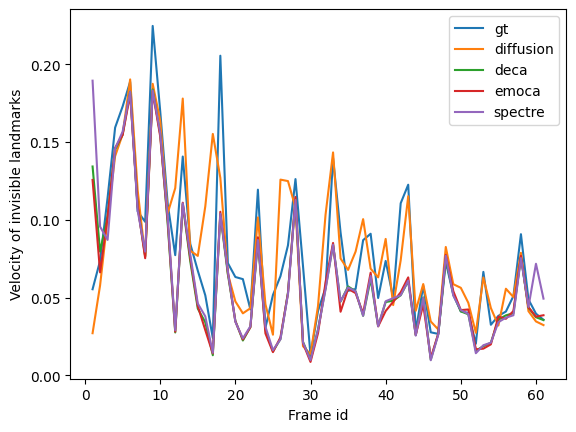

In [40]:
x = [i+1 for i in range(0, len(acc_dict['gt']['avg_acc']))] # frame id 

for model in acc_dict:
    y = acc_dict[model]['avg_acc_invis']
    plt.plot(x, y, label=model)
# plt.plot(x,k1,'s-',color = 'r',label="ATT-RLSTM")#s-:方形
# plt.plot(x,k2,'o-',color = 'g',label="CNN-RLSTM")#o-:圆形
plt.xlabel("Frame id")#横坐标名字
plt.ylabel("Velocity of invisible landmarks")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

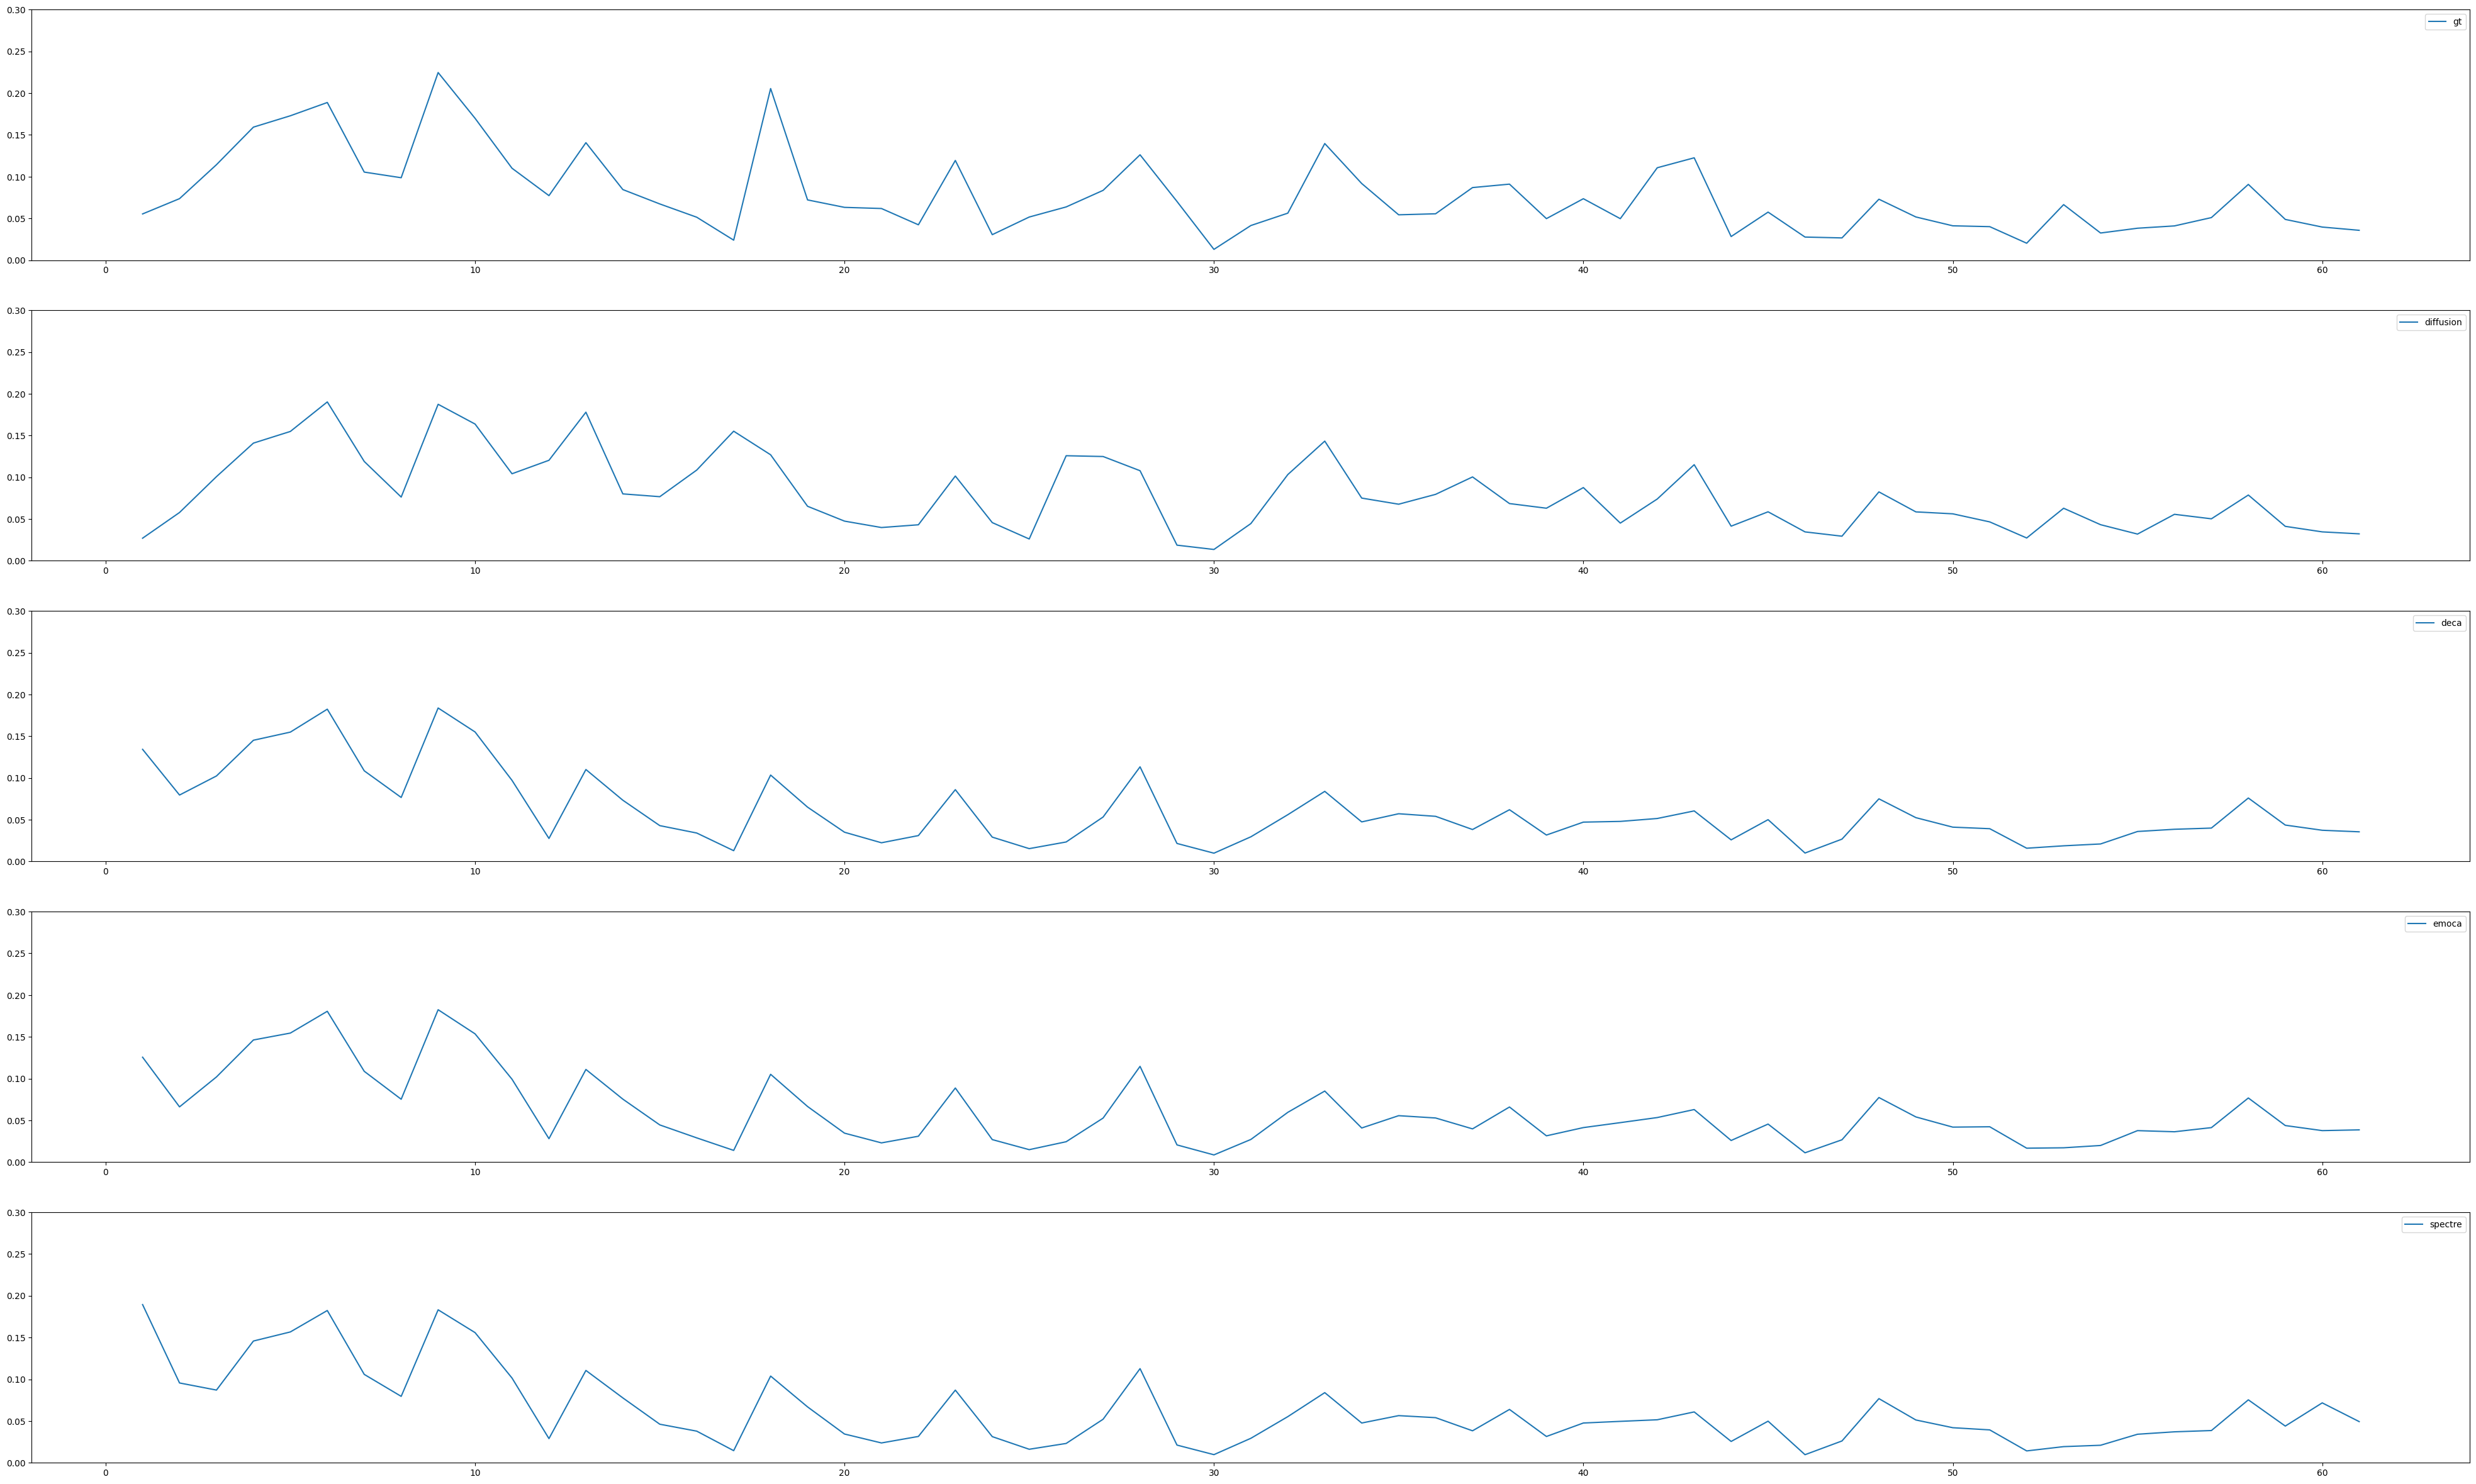

In [42]:
x = [i+1 for i in range(0, len(acc_dict['gt']['avg_acc']))] # frame id 

fig, axs = plt.subplots(5, 1, figsize=(50,30), sharey=True)

for i, model in enumerate(acc_dict.keys()):
    plt.subplot(5,1,i+1)
    y = acc_dict[model]['avg_acc_invis']
    plt.plot(x, y, label=model)
    plt.ylim(0,0.3)
    plt.legend(loc = "best")#图例
plt.show()